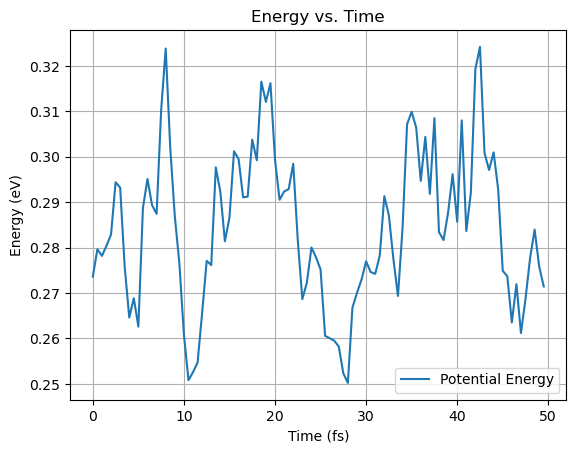

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def plot_energy(filename):
    # 데이터를 저장할 리스트 초기화
    data = []

    # 파일 읽기
    with open(filename, "r") as f:
        for line in f:
            # 줄 내용이 비어 있거나 주석(#)으로 시작하면 무시
            if line.strip() == "" or line.strip().startswith("#"):
                continue
            try:
                # 줄을 숫자로 변환하여 리스트에 추가
                data.append(list(map(float, line.split())))
            except ValueError:
                # 숫자로 변환할 수 없는 줄은 무시
                continue

    # 리스트를 NumPy 배열로 변환
    data = np.array(data)

    # 데이터가 적합한 형식인지 확인
    if data.shape[1] < 3:  # 최소 3열(스텝, 시간, 에너지)이 있어야 함
        raise ValueError("파일 형식이 잘못되었습니다. 최소 3개의 열이 필요합니다.")

    # 시간 및 에너지 데이터 추출
    time = data[:, 1]  # 2번째 열: 시간(fs)
    energy = data[:, 2]  # 3번째 열: 에너지(eV)

    # 그래프 그리기
    plt.figure()
    plt.plot(time, energy, label="Potential Energy")
    plt.xlabel("Time (fs)")
    plt.ylabel("Energy (eV)")
    plt.title("Energy vs. Time")
    plt.legend()
    plt.grid()
    plt.savefig("energy_vs_time.png")  # 그래프를 PNG 파일로 저장
    plt.show()

# 함수 호출
plot_energy("water_aimd_1ns_every0.5fs-1.ener")  # 파일 이름을 실제 이름으로 변경

In [11]:
def xyz_to_pdb(xyz_file, pdb_file, box_size=None):
    """
    XYZ 파일을 PDB 파일로 변환.
    
    Parameters:
    - xyz_file: str - 입력 XYZ 파일 경로
    - pdb_file: str - 출력 PDB 파일 경로
    - box_size: tuple - 박스 크기 (a, b, c), 단위는 Å. 기본값은 None.
    """
    with open(xyz_file, 'r') as xyz, open(pdb_file, 'w') as pdb:
        lines = xyz.readlines()
        
        # 첫 번째 줄: 원자 수
        num_atoms = int(lines[0].strip())
        
        # 두 번째 줄: 박스 크기 정보 (옵션)
        if box_size:
            pdb.write(f"CRYST1{box_size[0]:9.3f}{box_size[1]:9.3f}{box_size[2]:9.3f}  90.00  90.00  90.00 P 1           1\n")
        
        # 원자 데이터 변환
        pdb.write(f"TITLE     Converted from {xyz_file}\n")
        pdb.write("MODEL        1\n")
        
        for i, line in enumerate(lines[2:2+num_atoms], start=1):
            parts = line.split()
            element, x, y, z = parts[0], float(parts[1]), float(parts[2]), float(parts[3])
            pdb.write(f"HETATM{i:5d}  {element:<2}  MOL     1    {x:8.3f}{y:8.3f}{z:8.3f}  1.00  0.00           {element:<2}\n")
        
        pdb.write("ENDMDL\n")
        pdb.write("END\n")
    print(f"Converted {xyz_file} to {pdb_file}")

# 사용 예시
xyz_to_pdb(
    xyz_file="water_aimd_1ns_every0.5fs-pos-1.xyz",
    pdb_file="water.pdb",
    box_size=(12.42, 12.42, 12.42)  # 박스 크기 (Å)
)

Converted water_aimd_1ns_every0.5fs-pos-1.xyz to water.pdb


Number of O-O pairs: 4032


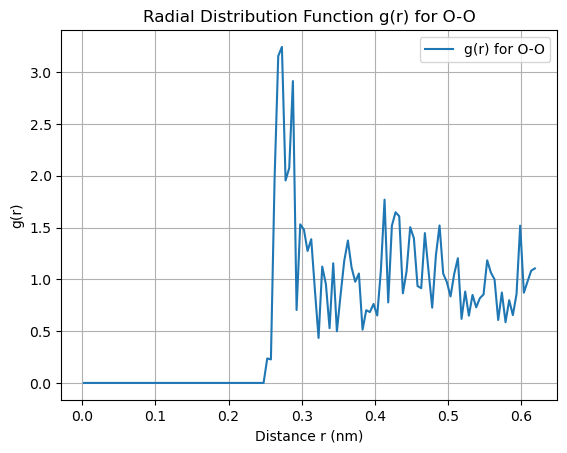

Number of O-H pairs: 8192


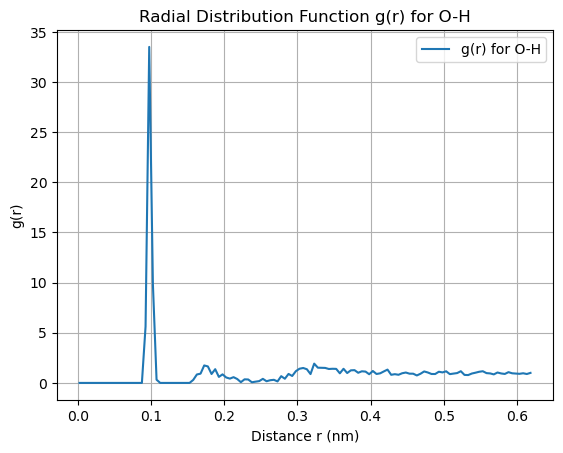

In [14]:
import mdtraj as md
import matplotlib.pyplot as plt
from itertools import combinations

def compute_pair_gr(traj_file, top_file, atom1, atom2, box_size, output_file):
    """
    특정 원자 쌍에 대한 g(r) 계산 및 시각화.

    Parameters:
    - traj_file: str - 트라젝토리 파일 (.pdb)
    - top_file: str - 구조 파일 (.pdb)
    - atom1: str - 첫 번째 원자 타입 (e.g., "O", "H")
    - atom2: str - 두 번째 원자 타입 (e.g., "H", "H")
    - box_size: float - 박스 크기 (nm)
    - output_file: str - 결과 그래프 저장 파일 이름 (.png)
    """
    # 트라젝토리 데이터 로드
    traj = md.load(traj_file, top=top_file)

    # 원자 선택
    indices1 = [atom.index for atom in traj.topology.atoms if atom.element.symbol == atom1]
    indices2 = [atom.index for atom in traj.topology.atoms if atom.element.symbol == atom2]

    # 원자 쌍 생성
    pairs = [(i, j) for i in indices1 for j in indices2 if i != j]
    print(f"Number of {atom1}-{atom2} pairs: {len(pairs)}")

    # g(r) 계산
    rdf, edges = md.compute_rdf(traj, pairs=pairs, r_range=(0, box_size / 2))
    r = edges[:len(rdf)]  # r 값 계산 (rdf 길이에 맞춤)

    # 그래프 그리기
    plt.figure()
    plt.plot(rdf, r, label=f"g(r) for {atom1}-{atom2}")
    plt.xlabel("Distance r (nm)")
    plt.ylabel("g(r)")
    plt.title(f"Radial Distribution Function g(r) for {atom1}-{atom2}")
    plt.legend()
    plt.grid()
    plt.savefig(output_file)
    plt.show()
    
box_size = 1.242  # 박스 크기 (nm)
compute_pair_gr("water.pdb", "water.pdb", "O", "O", box_size, "gr_oxygen_oxygen_water.png")

box_size = 1.242  # 박스 크기 (nm)
compute_pair_gr("water.pdb", "water.pdb", "O", "H", box_size, "gr_oxygen_hydrogen_proton.png")